In [36]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixture4Modes as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture4Modes/../utils.py'>

In [2]:
d = 2
weights = np.ones(4)/4
ms = np.array([[0, 8], [0, 2], [-3, 5], [3, 5]])
Sigmas = np.array([[[1.2, 0], [0, 0.01]], [[1.2, 0], [0, 0.01]], [[0.01, 0], [0, 2]],[[0.01, 0], [0, 2]]])

In [3]:
true_mean = np.mean(ms, axis = 0)
true_cov = np.zeros((d, d))
for i in range(4):
    true_cov += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_cov = true_cov/4

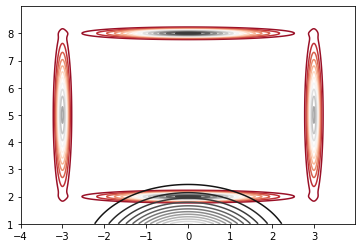

In [4]:
dx = .01
xx, yy = np.mgrid[-4:4:dx, 1:9:dx]
data = np.dstack((xx, yy))
z = 0
zinitial = multivariate_normal.pdf(data, np.array([0, 0]), np.eye(d))
for j in range(weights.size):
    z += weights[j]*multivariate_normal.pdf(data, ms[j,:], Sigmas[j,:,:])
plt.contour(xx, yy, z, 15, cmap='RdGy')
plt.contour(xx, yy, zinitial, 15, cmap = 'gray')

In [5]:
def gm2d_density(pos, ms, Sigmas, weights):
    z = 0
    for j in range(weights.size):
        z += weights[j]*multivariate_normal.pdf(pos, ms[j,:], Sigmas[j,:,:])
    return z

In [6]:
kde_pos = np.vstack([xx.ravel(), yy.ravel()])
true_density = gm2d_density(kde_pos.T, ms, Sigmas, weights)

## Algorithms

In [7]:
Niter = 500
gamma = 0.01
N = 500
h = gamma
X0 = np.random.multivariate_normal(np.array([0, 0]), np.eye(d), size = N)

In [8]:
component = np.random.randint(4, size = N)
true_sample = np.zeros((N, 2))
for n in range(N):
      true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)

In [17]:
Niter_ula = Niter*20
Niter_mala = Niter*5
Niter_fr = Niter*7
Niter_smcula = Niter*13
Niter_smcmala = Niter*4

In [18]:
Nalgo = 6
Nrep = 2

ula_chain = np.zeros((Nrep, Niter_ula, d, N))
mala_chain = np.zeros((Nrep, Niter_mala, d, N))
fr_x = np.zeros((Nrep, Niter_fr, d, N))
fr_w = np.zeros((Nrep, Niter_fr, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
smcula_x = np.zeros((Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Nrep, Niter_smcmala, N))

runtime = np.zeros((Nrep, Nalgo))

In [19]:
for i in range(Nrep):
    ### ULA
    start = time.time()
    ula_chain[i,:] = algo.ParallelULA(gamma, Niter_ula, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 0] = end-start
    ### MALA
    start = time.time()
    mala_chain[i,:] = algo.ParallelMALA(gamma, Niter_mala, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 1] = end-start
    ### SMC-FR
    start = time.time()
    fr_x[i,:], fr_w[i,:] = algo.SMC_UnitFR(gamma, Niter_fr, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 2] = end-start
    ### SMC-WFR
    start = time.time()
    wfr_x[i,:], wfr_w[i,:] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 3] = end-start
    ### SMC-ULA
    start = time.time()
    smcula_x[i,:], smcula_w[i,:] = algo.SMC_ULA(gamma, Niter_smcula, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 4] = end-start
    ### SMC-MALA
    start = time.time()
    smcmala_x[i,:], smcmala_w[i,:] = algo.SMC_MALA(gamma, Niter_smcmala, ms, Sigmas, weights, X0)
    end = time.time()
    runtime[i, 5] = end-start

In [20]:
avg_runtime = np.mean(runtime, axis = 0)
avg_runtime

array([5.30849648, 6.09782445, 4.87762094, 6.87847781, 6.0582099 ,
       6.68645942])

In [27]:
xx_ula = avg_runtime[0]/Niter_ula*np.arange(Niter_ula)
xx_mala = avg_runtime[1]/Niter_mala*np.arange(Niter_mala)
xx_fr = avg_runtime[2]/Niter_fr*np.arange(Niter_fr)
xx_wfr = avg_runtime[3]/Niter*np.arange(Niter)
xx_smcula = avg_runtime[4]/Niter_smcula*np.arange(Niter_smcula)
xx_smcmala = avg_runtime[5]/Niter_smcmala*np.arange(Niter_smcmala)

In [24]:
diag_ula = np.zeros((Nrep, Niter_ula, 6))
diag_mala = np.zeros((Nrep, Niter_mala, 6))
diag_fr = np.zeros((Nrep, Niter_fr, 6))
diag_wfr = np.zeros((Nrep, Niter, 6))
diag_smcula = np.zeros((Nrep, Niter_smcula, 6))
diag_smcmala = np.zeros((Nrep, Niter_smcmala, 6))

In [37]:
for i in range(Nrep):
    diag_ula[i, :] = u.diagnosticsHD(ula_chain[i, :], Niter_ula, 3, true_sample, true_mean, true_cov, kde_pos, true_density, dx)
    diag_wfr[i, :] = u.diagnosticsHD(wfr_x[i, :], Niter, 3, true_sample, true_mean, true_cov, kde_pos, true_density, dx, w = wfr_w[i, :])


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)
plt.plot(xx_ula, np.mean(diag_ula[:, :, 3], axis = 0))
plt.plot(xx_mala, np.mean(diag_mala[:, :, 3], axis = 0))
plt.plot(xx_fr, np.mean(diag_fr[:, :, 3], axis = 0))
plt.plot(xx_wfr, np.mean(diag_wfr[:, :, 3], axis = 0))
plt.plot(xx_smcula, np.mean(diag_smcula[:, :, 3], axis = 0))
plt.plot(xx_smcmala, np.mean(diag_smcmala[:, :, 3], axis = 0))
plt.subplot(1, 3, 2)
plt.plot(xx_ula, np.mean(diag_ula[:, :, 4], axis = 0))
plt.plot(xx_mala, np.mean(diag_mala[:, :, 4], axis = 0))
plt.plot(xx_fr, np.mean(diag_fr[:, :, 4], axis = 0))
plt.plot(xx_wfr, np.mean(diag_wfr[:, :, 4], axis = 0))
plt.plot(xx_smcula, np.mean(diag_smcula[:, :, 4], axis = 0))
plt.plot(xx_smcmala, np.mean(diag_smcmala[:, :, 4], axis = 0))
plt.subplot(1, 3, 3)
plt.plot(xx_ula, np.mean(diag_ula[:, :, 5], axis = 0))
plt.plot(xx_mala, np.mean(diag_mala[:, :, 5], axis = 0))
plt.plot(xx_fr, np.mean(diag_fr[:, :, 5], axis = 0))
plt.plot(xx_wfr, np.mean(diag_wfr[:, :, 5], axis = 0))
plt.plot(xx_smcula, np.mean(diag_smcula[:, :, 5], axis = 0))
plt.plot(xx_smcmala, np.mean(diag_smcmala[:, :, 5], axis = 0))
plt.plot(xx_wfr, mmd_wfr)